In [ ]:
w#pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

#Importing the dataset 
1. The dataset is given in a online hackathon by NETFLIX asking participants to Suggest the New movies for users based on their previous ratings given by all users. 
2. all the datasets are imported one by one and they are combined to make the final complete dataset.

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project/combined_data_1.txt', header = None, names = ['Customer_Id', 'Rating'])
df2 = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project/combined_data_2.txt', header = None, names = ['Customer_Id', 'Rating'])
df3 = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project/combined_data_3.txt', header = None, names = ['Customer_Id', 'Rating'])       #importing thr datasets from drive
df4 = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project/combined_data_4.txt', header = None, names = ['Customer_Id', 'Rating'])



df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)                   #converting the rating variable into float type.
df4['Rating'] = df4['Rating'].astype(float)


d = df1
d = d.append(df1)
d = d.append(df2)                                             # appending the datasets into one
d = d.append(df3)
d = d.append(df4)

# data view
1. as we can see the data is organised in a way that first comes the movie id and then comes the raing given by all users to that movie
2. There are four datasets given that contain rating given by users for each movie 
3. Dimensions  97,704,614 X 2 => 97.7 Million user ratings . A Total of l 17,434 movies listed. Need to extract features directly from patterns in data

In [ ]:
print(d.shape)
d.head()

(97704614, 2)


,Customer_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print(df.iloc[::, :])
df.head()

Full dataset shape: (97704614, 2)
-Dataset examples-
         Customer_Id  Rating
0                 1:     NaN
1            1488844     3.0
2             822109     5.0
3             885013     4.0
4              30878     4.0
...              ...     ...
97704609     2339129     4.0
97704610       59005     4.0
97704611     1789683     5.0
97704612     1878798     1.0
97704613     2634967     1.0

[97704614 rows x 2 columns]


,Customer_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


## Plotting the user ratings
1. the below graph gives the approximation about the number of users and movies and also the number of ratings given by them

2. The are a total of 474,954 Customers A total of 17,866 Movies 97 Million Customer ratings given 
3. The ratings are a bit Positively biased as only satisfied customers keep using the platform Mostly the people who are unsatisfied prefer leaving the Platform rather than rating for bad movies.

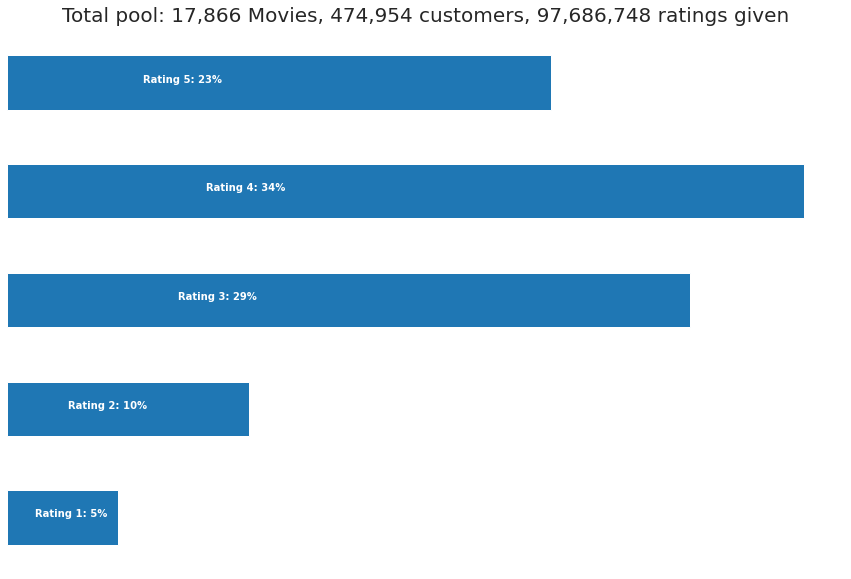

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie and customer count count
total_movies    = df.isnull().sum()[1]
total_customers = df['Customer_Id'].nunique() - total_movies
total_ratings   = df['Customer_Id'].count()   - total_movies

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(total_movies, total_customers, total_ratings ), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [ ]:
#taking the movie_id from the df and appending as a column in each iteration
#to get the movie_id we look for Nan values in the ratings column and use that as a seperator between one movie ratinf and the other
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

#start with initilising the movie_id variable as 1 adn keep on incrementing it tilll it reaches the end 
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
#need to handle the last record saperately as the last part filling the last few rows with the movie_id to match the size of the dataframe
last = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last)

## **Slicing and cleaning the dataset Part 1**
1. Data is Huge with 96 Million ratings so its impossible to use for prediction, kernel runs out of memory.
2. Removing Movies that have few reviews(Non popular Movies)
3. Removing customers who had given less reviews(Less active Users)
4. Keeping recourses in mind taking only top 70% of movies and ratings

In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)

movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)

drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index


df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))
print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


## Final Dataset
1. The below is the original and final shape of the dataset after all the preprocessings are done and now this will be used for creating the final recommendation system.
2. containing Cust_id, Rating, Movie_id as columns

In [ ]:
print('Original Shape: {}'.format(df.shape))
# triming the dataset by removing the contetns in the swap list
df = df[~df['Movie_Id'].isin(drop_movie_list)] 
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print(df.iloc[::100, :])

Original Shape: (4057475, 3)
After Trim Shape: (1537342, 3)
-Data Examples-
         Cust_Id  Rating  Movie_Id
5110      243963     3.0         8
5424     2430016     4.0         8
5755      107840     2.0         8
6121       96124     3.0         8
6448     1059428     3.0         8
...          ...     ...       ...
4057155  1632290     4.0       788
4057397  1716677     5.0       788
4057697  1888501     3.0       788
4057908   150869     4.0       788
4058140  1620331     4.0       788

[15374 rows x 3 columns]


## **Creating adjacancy matrix**
* here we are creating a pivot table which will be having the all users and the movies they have rated so far.
* now our task is to predict the unkown ratings using the known ones even though the user havent seen it.

In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(143458, 1350)


In [ ]:
df_title = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project/movie_titles.csv', encoding = "latin", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head())

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW


To estimate all the unknown, we minimize the following regularized squared
error
The minimization is performed by a very straightforward stochastic gradient
descent

In [ ]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)

#Building the model 
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
df_c = df[(df['Cust_Id'] == 7) & (df['Rating'] == 5)]
df_c = df_c.set_index('Movie_Id')
df_c = df_c.join(df_title)['Name']
print(df_c)

Movie_Id
8      What the #$*! Do We Know!?
30         Something's Gotta Give
83                       Silkwood
175                Reservoir Dogs
257               Charlotte's Web
283     If These Walls Could Talk
285               The Devil's Own
313                Pay It Forward
357         House of Sand and Fog
457             Kill Bill: Vol. 2
468       The Matrix: Revolutions
501      Three Days of the Condor
550                  First Knight
689                One True Thing
Name: Name, dtype: object


In [ ]:
user_7 = df_title.copy()
user_7 = user_7.reset_index()
user_7 = user_7[~user_7['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_7['Estimate_Score'] = user_7['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_7 = user_7.drop('Movie_Id', axis = 1)

user_7 = user_7.sort_values('Estimate_Score', ascending=False)
print(user_7.head(10))

       Year                                           Name  Estimate_Score
751  1993.0       Star Trek: The Next Generation: Season 7        4.203840
222  2003.0                     Chappelle's Show: Season 1        4.199803
240  1959.0                             North by Northwest        4.154098
315  1999.0  Futurama: Monster Robot Maniac Fun Collection        4.136601
576  1961.0                     The Twilight Zone: Vol. 36        4.111651
358  2003.0                  Absolutely Fabulous: Series 5        4.106950
174  1992.0                                 Reservoir Dogs        4.098080
252  1935.0                           A Night at the Opera        4.082527
462  1962.0                     The Twilight Zone: Vol. 12        4.072753
721  2003.0                             The Wire: Season 1        4.062626
